In [1]:
import torch
import torch.nn as nn
from datasets import IMDBHypergraphDataset, collate_fn, train_test_split, ARXIVHypergraphDataset, COURSERAHypergraphDataset
from torch.utils.data import DataLoader
from torch_geometric.nn import HypergraphConv
import matplotlib.pyplot as plt
from tqdm.auto import trange, tqdm
from torch_geometric.data.hypergraph_data import HyperGraphData
from torch_geometric.nn.aggr import MeanAggregation
from sklearn.metrics import confusion_matrix, roc_auc_score
from torch.utils.tensorboard import SummaryWriter

/home/dariodemaio/Documents/Contextual_HLP/.venv/lib/python3.13/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
from sklearn.metrics import roc_curve
import numpy as np

def sensivity_specificity_cutoff(y_true, y_score):
    fpr, tpr, thresholds = roc_curve(y_true, y_score)
    idx = np.argmax(tpr - fpr)
    return thresholds[idx]

In [3]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
device

device(type='cuda')

## Load the Dataset

In [4]:
def pre_transform(data: HyperGraphData):
    data.edge_index = data.edge_index[:, torch.isin(data.edge_index[1], (data.edge_index[1].bincount() > 1).nonzero())]
    unique, inverse = data.edge_index[1].unique(return_inverse=True)
    data.edge_attr = data.edge_attr[unique]
    data.edge_index[1] = inverse
    return data

In [5]:
dataset = COURSERAHypergraphDataset("./data", pre_transform=pre_transform)
train_dataset, test_dataset, _, _, _, _ = train_test_split(dataset, test_size=0.4)
# Train dataset is for train
# Test indices for evaluation (the forward pass is performed on the whole network)

In [6]:
from random import randint
writer = SummaryWriter(f"./logs/{dataset.DATASET_NAME}/{randint(0, 10000)}/")

In [7]:
# dataset._data.x = torch.randn_like(dataset._data.x)
# dataset._data.edge_attr = torch.randn_like(dataset._data.edge_attr)

## Training

In [8]:
loader = DataLoader(
    train_dataset,
    collate_fn=collate_fn,
    batch_size=100,
    num_workers=8,        # Uncomment for faster loading
    pin_memory=True,      # Uncomment for faster loading
    shuffle=True,
    drop_last=True
)

### Initalize the model

In [9]:
class Model(nn.Module):
    
    def __init__(self,
                 in_channels: int,
                 hidden_channels: int,
                 out_channels: int,
                 num_layers: int = 1):
        super(Model, self).__init__()
        self.dropout = nn.Dropout(0.3)
        self.activation = nn.LeakyReLU()
        self.in_norm = nn.LayerNorm(in_channels)
        self.in_proj = nn.Linear(in_channels, hidden_channels)
        self.e_proj = nn.Linear(in_channels, hidden_channels)
        self.e_norm = nn.LayerNorm(in_channels)

        for i in range(num_layers):
            setattr(self, f"n_norm_{i}", nn.LayerNorm(hidden_channels))
            setattr(self, f"e_norm_{i}", nn.LayerNorm(hidden_channels))
            setattr(self, f"hgconv_{i}", HypergraphConv(
                hidden_channels,
                hidden_channels,
                use_attention=True,
                concat=False,
                heads=1
            ))
            setattr(self, f"skip_{i}", nn.Linear(hidden_channels, hidden_channels))
        self.num_layers = num_layers

        self.aggr = MeanAggregation()
        self.linear = nn.Linear(hidden_channels, out_channels)

    def forward(self, x, x_e, edge_index):
        x = self.in_norm(x)
        x = self.in_proj(x)
        x = self.activation(x)
        x = self.dropout(x)

        x_e = self.e_norm(x_e)
        x_e = self.e_proj(x_e)
        x_e = self.activation(x_e)
        x_e = self.dropout(x_e)

        for i in range(self.num_layers):
            n_norm = getattr(self, f"n_norm_{i}")
            e_norm = getattr(self, f"e_norm_{i}")
            hgconv = getattr(self, f"hgconv_{i}")
            skip = getattr(self, f"skip_{i}")
            x = n_norm(x)
            x_e = e_norm(x_e)
            x = self.activation(hgconv(x, edge_index, hyperedge_attr=x_e)) + \
                skip(x)

        x = self.aggr(x[edge_index[0]], edge_index[1])
        x = self.linear(x)
        return x

In [16]:
model = Model(
    in_channels=dataset.num_features,
    hidden_channels=256,
    out_channels=1
).to(device)
optimizer = torch.optim.Adam(model.parameters(), lr=0.00001)
criterion = torch.nn.BCEWithLogitsLoss()
test_criterion = torch.nn.BCELoss()

In [17]:
def negative_sampling(h: HyperGraphData):
    edge_index = h.edge_index.clone()
    edge_index[0] = torch.randint(0, h.num_nodes, (edge_index[1].shape[0], ), device=h.x.device)
    h_edge_attr = torch.vstack((h.edge_attr, h.edge_attr))
    h.y = torch.vstack((
        torch.ones((h.edge_index[1].max() + 1, 1), device=h.x.device),
        torch.zeros((edge_index[1].max() + 1, 1), device=h.x.device),
    ))
    edge_index[1] += edge_index[1].max() + 1
    edge_index = torch.hstack((h.edge_index, edge_index))
    h_ = HyperGraphData(
        x=h.x,
        edge_index=edge_index,
        edge_attr=h_edge_attr,
        y=h.y,
        num_nodes=h.num_nodes,
    )
    return h_

In [20]:
test_dataset_ = negative_sampling(test_dataset._data).to(device)
for epoch in trange(10):
    model.train()
    # 1. Zero gradients
    optimizer.zero_grad()
    for i, h in tqdm(enumerate(loader), leave=False):
        h = h.to(device)
        h_ = negative_sampling(h)
        y_train = model(h_.x, h_.edge_attr, h_.edge_index)
        loss = criterion(y_train, h_.y)
        loss.backward()
        writer.add_scalar("Loss/train", loss.item(), epoch * len(loader) + i)
    optimizer.step()

    model.eval()
    with torch.no_grad():
        y_test = model(test_dataset_.x.to(device), test_dataset_.edge_attr.to(device), test_dataset_.edge_index.to(device)) # The test forward is performed on the whole network
        y_test = torch.sigmoid(y_test)
        loss = test_criterion(y_test, test_dataset_.y)
        writer.add_scalar("Loss/test", loss.item(), epoch)
        roc_auc = roc_auc_score(test_dataset_.y.cpu().numpy(), y_test.cpu().numpy())
        writer.add_scalar("ROC_AUC/test", roc_auc, epoch)

100%|██████████| 10/10 [00:03<00:00,  3.05it/s]


In [ ]:
torch.save(model, 'entire_model.pth')

## Evaluation

<Axes: >

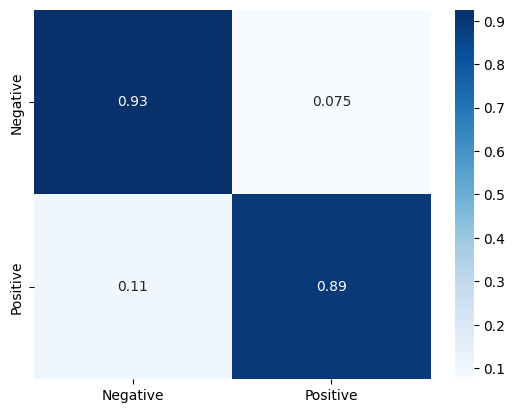

In [19]:
import seaborn as sns

cutoff = sensivity_specificity_cutoff(test_dataset_.y.cpu().numpy(), y_test.cpu().numpy())
cm = confusion_matrix(
    test_dataset_.y.cpu().numpy(),
    (y_test > cutoff).cpu().numpy(),
    labels=[0, 1],
    normalize='true'
)
sns.heatmap(cm, annot=True, cmap='Blues', xticklabels=['Negative', 'Positive'], yticklabels=['Negative', 'Positive'])

## Evaluation

In [ ]:
torch.save(test_dataset, 'test_dataset.pth')

AttributeError: Can't get local object 'train_test_split.<locals>.TestDataset'

In [ ]:
torch.save(train_dataset, 'train_dataset.pth')

In [ ]:
torch.save(loader, 'loader.pth')

In [ ]:
for i in range(19):
    test_dataset_ = negative_sampling(test_dataset)
    y_test = model(test_dataset_.x.to(device), test_dataset_.edge_attr.to(device), test_dataset_.edge_index.to(device)) # The test forward is performed on the whole network
    y_test = torch.sigmoid(y_test)
    roc_auc = roc_auc_score(test_dataset_.y.cpu().numpy(), y_test.detach().cpu().numpy())
    print(roc_auc)

0.8284078220887882
0.8244632708964201
0.8270478599582132
0.8270715366340654
0.8250100013507919
0.8288865338828547
0.8280987389655856
0.8245213770067454
0.8267536998327248
0.828201760654126
0.8281269491565808
0.8271206829973824
0.8260570394043789
0.8273067419429025
0.8265697398154901
0.826025685069798
0.8274246813181038
0.8293747779554814
0.8263814194234519
